In [1]:
from process_ocean_data.read import rbr as rbr
from process_ocean_data.tools import process as process

import pandas as pd
import xarray as xr
import json

import gsw

# Read RBR Solo data from RText Format
Read original data and transform to L0 NetCDF format


In [2]:
# Read RText Data
df,meta = rbr.rtext('079156_20200829_1606_eng.txt')

# Convert "Date & Time" to datetime 
df['time'] = pd.to_datetime(df['Date & Time'],utc=True).dt.tz_localize(None)

# Convert to an xarray format
ds = df.set_index('time').to_xarray()

# Add Metadata Documentation
# Add metadata to each variables and derive more
ds['instrument'] = f"{meta['Model']} SN{meta['Serial']}"
ds['work_area'] = 'Calvert'
ds['station'] = 'CP1'
ds['latitude'] = 51+40.240/60
ds['latitude'].attrs = {
    'long_name':'Latitude',
    'standard_name':'latitude',
    'units': 'degree_north'
}
ds['longitude'] = -(128+7.262/60)
ds['longitude'].attrs = {
    'long_name':'Longitude',
    'standard_name':'longitude',
    'units': 'degree_east'
}

ds['dpth01'].attrs = {
    'long_name': 'Instrument Depth',
    'units':'m',
    'standard_name':'depth'
}
ds['pres20'].attrs = {
    'long_name': 'Pressure',
    'units': 'dBar',
    'standard_name': 'sea_water_pressure'
}
ds['pres08'].attrs = {
    'long_name': 'Sea Pressure',
    'units': 'dBar',
    'standard_name': 'sea_water_pressure_at_sea_water_surface',
    'comments': 'Pressure corrected with an offset of 10.1325 dBar.'
}

# Global Attributes
ds.attrs = {
    'title': 'Seabed Pressure time series from a Pressure Tide Gauge Instrument',
    'organization': 'Hakai Institute',
    'summary': (
        'This dataset present a time series of water level measurements made by an RBR Solo pressure sensor '+
        'deployed by the Hakai Institute near the Calvert Island Research Station in the coastal region of Choke Pass. ' +
        ''
        ),
    'instrument': meta['Model'],
    'instrument_serial': meta['Serial'],
    'instrument_firmware': meta['Firmware'],
    'instrument_calibration': json.dumps(meta['Channel']),
    'history':f"Extract RBR Solo data with Ruskin software",
    'original_header': json.dumps(meta)
}

# Save file as L0
file_name = (
    f"Hakai_{ds['instrument'].str.replace(' ','-').values}_"+
    f"{ds['work_area'].values}-{ds['station'].values}_"+
    f"{ds['time'].min().dt.strftime('%Y%M%d').values}-{ds['time'].max().dt.strftime('%Y%M%d').values}"
)
ds.to_netcdf(file_name+'_L0.nc')

Ignored: 

Ignored: 

Ignored: 



c:\users\jessy\documents\repositories\process_ocean_timeseries\process_ocean_data\read\rbr.py:50: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



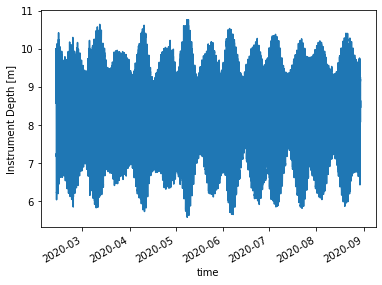

In [3]:
# Cropped data in the water only
in_water_time = ds.where((ds['dpth01']>3) & (abs(ds['dpth01'].diff(dim='time'))<1),drop=True)['time']
ds_in_water = ds.where((ds['time']>=in_water_time.min()) & (ds['time']<=in_water_time.max()), drop=True)
ds_in_water['dpth01'].plot()


# Remove Air Pressure Component
We'll use the Pruth Dock Air Pressure

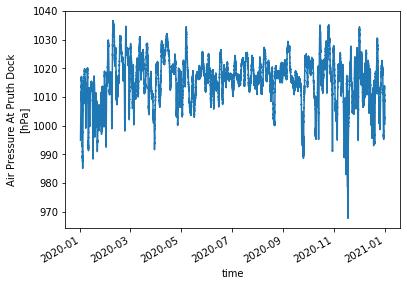

In [19]:
# Get Data and shift timezone to UTC and then unaware timezone
df_dock = pd.read_csv('2021-09-23.5minuteSamples.2020.csv', skiprows=[1,2,3])
df_dock['time'] = pd.to_datetime(df_dock['Measurement time']+'-08:00').dt.tz_convert('UTC').dt.tz_localize(None)-pd.to_timedelta('2min')

# Add Dock Time series to Choke Pass Timeseries
ds_dock = df_dock.set_index('time').to_xarray()
ds_dock['StationAirPressure'].attrs = {
    'long_name': 'Air Pressure At Pruth Dock',
    'units': 'hPa',
    'standard_name': 'air_pressure',
    'cell_method': 'last: 5min interval'
}
ds_dock['StationAirPressureAvg'].attrs = {
    'long_name': 'Air Pressure At Pruth Dock',
    'units': 'hPa',
    'standard_name': 'air_pressure',
    'cell_method': 'mean: 5min interval'
}

ds_dock['PruthTideHeightAvg'].attrs = {
    'long_name': 'Water Level at Pruth Dock',
    'units': 'm',
    'standard_name': 'air_pressure',
    'cell_method': 'mean: 5min interval'
}
ds_dock['PruthTideHeightMed'].attrs = {
    'long_name': 'Water Level at Pruth Dock',
    'units': 'm',
    'cell_method': 'median: 5min interval'
}

# Drop Flagged Data
ds_dock = ds_dock.where((ds_dock['StationAirPressureUNESCO_Q_level']!=1),drop=True)

ds_dock['StationAirPressure'].plot()

In [18]:
len(ds['instrument'].dims)==0

True

In [20]:
# Add Dock Time series to Choke Pass Timeseries by resampling both at 5min intervals and linearly interpolating =
resample_input = {'time': '5min'}
interpolated_timeseries = [
    ds_in_water.resample(resample_input).interpolate('linear'),
    ds_dock[['StationAirPressure','PruthTideHeightAvg']].resample(resample_input).interpolate('linear')
    ]
ds_with_air = xr.combine_by_coords(interpolated_timeseries)
ds_with_air.attrs['history'] += "\nRetrieve Atmospheric Pressure measured from Hakai's Pruth Dock Weather Station."

# Add Back Constant Variables
for var in ds:
    if len(ds[var].dims)==0:
        ds_with_air[var] = ds[var]

# Convert Station Air Pressure from hPa to dBar
ds_with_air['StationAirPressure_dbar'] = ds_with_air['StationAirPressure']/100
ds_with_air.attrs['history'] += "\nConvert Atmospheric pressure to dBar."

# Substract Air Pressure From Instrument Pressure
ds_with_air['Sea Pressure'] = ds_with_air['pres20'] - ds_with_air['StationAirPressure_dbar']
ds_with_air.attrs['history'] += "\nSubstract atmospheric pressure from measured sea water pressure."

# Compute Depth from Sea Pressure at bottom
ds_with_air['depth'] = (ds_with_air['Sea Pressure'].dims, -gsw.z_from_p(ds_with_air['Sea Pressure'],ds['latitude']))
ds_with_air.attrs['history'] += "\nDerive depth from corrected sea water pressure."


In [21]:
# Separate new dataset
ds_final = ds_with_air

# Generate a water_level variable centered around mean sea level
ds_final['water_height'] = ds_final['depth']-ds_final['depth'].mean()
ds_final.attrs['history'] += '\n Generated a water_level variable centered around the mean sea level.'

In [22]:
import plotly.graph_objects as go

fig = go.Figure()
# fig.add_trace(go.Scatter(x=ds_final['time'],y=ds_final['PruthTideHeightAvg']-ds_final['PruthTideHeightAvg'].mean()))
# fig.add_trace(go.Scatter(x=ds_final['time'],y=ds_final['depth']-ds_final['depth'].mean()))
fig.add_trace(go.Scatter(x=ds_final['time'].to_dataframe().index,y=ds_final['depth']-ds_final['PruthTideHeightAvg']-5.5))
fig.show()


In [23]:
ds_final['StationAirPressure_dbar'].attrs = ds_final['StationAirPressure'].attrs
ds_final['StationAirPressure_dbar'].attrs['units'] = 'dBar'

ds_final['Sea Pressure'].attrs = {
    'long_name': "Atmosphere Corrected Sea Pressure",
    'units': 'dBar',
    'standard_name': 'sea_water_pressure',
    'comments': 'Sea Water Pressure Measured from Sea Pressure insitu sensor and corrected for atmospheric pressure with Hakai Pruth Dock Atmospheric Pressure data.'
    }
ds_final['depth'].attrs = {
    'long_name': 'Instrument Depth',
    'units': 'm',
    'standard_name': 'depth'
}

ds_final['water_height'].attrs = {
    'long_name': 'Water Level Above Mean Sea Level',
    'units': 'm',
    'standard_name': 'height_above_mean_sea_level'
}

In [24]:
# Save Data To NetCDF
ds_final.to_netcdf(file_name+'_L1.nc')

In [25]:
ds_final

<xarray.Dataset>
Dimensions:                  (time: 105408)
Coordinates:
  * time                     (time) datetime64[ns] 2020-01-01T08:00:00 ... 20...
Data variables: (12/14)
    StationAirPressure       (time) float64 nan 995.0 ... 1.001e+03 1.001e+03
    PruthTideHeightAvg       (time) float64 nan 1.9 1.939 ... 2.977 3.055 3.135
    pres20                   (time) float64 nan nan nan nan ... nan nan nan nan
    pres08                   (time) float64 nan nan nan nan ... nan nan nan nan
    dpth01                   (time) float64 nan nan nan nan ... nan nan nan nan
    latitude                 float64 51.67
    ...                       ...
    work_area                <U7 'Calvert'
    station                  <U3 'CP1'
    StationAirPressure_dbar  (time) float64 nan 9.95 9.951 ... 10.01 10.01 10.01
    Sea Pressure             (time) float64 nan nan nan nan ... nan nan nan nan
    depth                    (time) float64 nan nan nan nan ... nan nan nan nan
    water_height             (time) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    title:                   Seabed Pressure time series from a Pressure Tide...
    organization:            Hakai Institute
    summary:                 This dataset present a time series of water leve...
    instrument:              RBRsolo
    instrument_serial:       079156
    instrument_firmware:     3.270
    instrument_calibration:  {"1": {"name": "Pressure", "calibration": "35.32...
    history:                 Extract RBR Solo data with Ruskin software\nRetr...
    original_header:         {"header_info": {}, "Model": "RBRsolo", "Firmwar...

In [1]:
ds

NameError: name 'ds' is not defined